In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

import jax.numpy as jnp
from jax import random, vmap, pmap, local_devices
from jax import pmap, local_devices, local_device_count, process_index, device_get
from jax.scipy.stats import multivariate_normal
from jax import image

import numpy as np
from tqdm.auto import trange

import sys
sys.path.append("./")
sys.path.append("./volcano")


from configs.default import get_config

import matplotlib.pyplot as plt
# from matplotlib import style
# style.use('dark_background')
%matplotlib inline

print(local_devices())

[StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0)]


In [2]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rc('font', family='serif')
plt.rcParams.update({
                      "text.usetex": True,
                      "font.family": "serif",
                      'text.latex.preamble': r'\usepackage{amsmath}',
                      'font.size': 20,
                      'lines.linewidth': 3,
                      'axes.labelsize': 22,  
                      'axes.titlesize': 24,
                      'xtick.labelsize': 20,
                      'ytick.labelsize': 20,
                      'legend.fontsize': 20,
                      'axes.linewidth': 2})

In [3]:
# Load bumps data
def sample_u(rng_key, X, n):
    k1, k2 = random.split(rng_key)
    mu = random.uniform(k1, (2,), minval=0.0, maxval=1.0)
    sigma = random.uniform(k2, (1,), minval=0.0, maxval=0.01) + 0.001
    u = multivariate_normal.pdf(X, mu, sigma*jnp.eye(2))
    w = 1.0/jnp.linalg.norm(u, 2)**2
    return u.reshape(n,n).T[...,jnp.newaxis], X, u[:,None], jnp.tile(w, (X.shape[0],1))

N = 4096
m = 48
num_channels = 1

x = jnp.linspace(0,1,m)
y = jnp.linspace(0,1,m)
grid = jnp.meshgrid(x,y)
X = jnp.array(grid).T.reshape(-1,2)

# Generate training samples
key = random.PRNGKey(0)
keys = random.split(key, N)
gen_fn = lambda key: sample_u(key, X, m)
u_1, y_1, s_1, _ = vmap(gen_fn)(keys)

In [4]:
# Load CH data
N = 4096
m = 64
num_channels = 1

resize = lambda x: image.resize(x, shape=(m,m,num_channels), method='bilinear')

data_buf = np.load('cahn_hilliard_patterns.npy')
num_examples = data_buf.shape[0]

key = random.PRNGKey(0)
idx = random.choice(key, num_examples, (N,), replace=False)
train_X = jnp.array(data_buf[idx,...])
train_X = vmap(resize)(train_X)

def get_example(u, X, n):
    u = jnp.flipud(u)
    s = u.reshape(-1,1)
    return u, X, s, jnp.tile(1.0, (X.shape[0],1))

N, m, _, num_channels = train_X.shape

x = np.linspace(0,1,m)
y = np.linspace(0,1,m)
grid = np.meshgrid(x,y)
X = jnp.array(grid).T.reshape(-1,2)

gen_fn = lambda u: get_example(u, X, m)
u_2, y_2, s_2, _ = vmap(gen_fn)(train_X)

In [5]:
# Load volcano data
volcano_data = jnp.load('volcano.npy')
N, m, _, num_channels = volcano_data.shape

def get_example(u, X, n):
    s = u.reshape(-1,num_channels)
    # w = 1.0/jnp.linalg.norm(s, 2, axis=0)**2
    return u, X, s, jnp.tile(1.0, (X.shape[0],1))

def volcano_phase(samples):
    phase = jnp.arctan2(samples[...,1], samples[...,0])
    phase = (phase + jnp.pi) % (2 * jnp.pi) - jnp.pi
    return phase

x = jnp.linspace(0,1,m)
y = jnp.linspace(0,1,m)
grid = jnp.meshgrid(x,y)
X = jnp.array(grid).T.reshape(-1,2)

gen_fn = lambda u: get_example(u, X, m)

# Generate training samples
gen_fn = lambda u: get_example(u, X, m)
u_3, y_3, s_3, _ = vmap(gen_fn)(volcano_data)
u_3 = volcano_phase(u_3)

In [6]:
# Load trained models
from bumps_2d.configs.default import get_config
from bumps_2d.models import VAE
from bumps_2d.archs import MLP, periodic_encoding
from bumps_2d.utils import restore_checkpoint
config_1 = get_config()
model_1 = VAE(config_1)
model_1 = restore_checkpoint(model_1, './bumps_2d/nonlinear_decoder_checkpoint_20000')

from cahn_hilliard.configs.default import get_config
from cahn_hilliard.models import VAE
from cahn_hilliard.archs import MLP, periodic_encoding
from cahn_hilliard.utils import restore_checkpoint
config_2 = get_config()
model_2 = VAE(config_2)
model_2 = restore_checkpoint(model_2, './cahn_hilliard/checkpoint_20000')

from volcano.configs.default import get_config
from volcano.models import VAE
from volcano.archs import MLP, periodic_encoding
from volcano.utils import restore_checkpoint
config_3 = get_config()
model_3 = VAE(config_3)
model_3 = restore_checkpoint(model_3, './volcano/h512_eps256_beta1e-4_checkpoint_25000')



2023-01-25 19:16:45.920890: E tensorflow/tsl/lib/monitoring/collection_registry.cc:81] Cannot register 2 metrics with the same name: /tensorflow/core/bfc_allocator_delay



                             NeuralOperator Summary                             
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ path          ┃ module        ┃ inputs        ┃ outputs      ┃ params        ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│               │ NeuralOperat… │ -             │ float32[1,1] │               │
│               │               │ float32[1,48… │              │               │
│               │               │ -             │              │               │
│               │               │ float32[1,2]  │              │               │
│               │               │ - float32[32] │              │               │
├───────────────┼───────────────┼───────────────┼──────────────┼───────────────┤
│ encoder       │ ConvEncoder   │ -             │ -            │               │
│               │               │ float32[1,48… │ float32[32]  │               │
│               │          

In [8]:
# Generate samples
run_idx = 0
key = random.PRNGKey(run_idx)

num_samples = 4
batch_size = 1
num_devices = local_device_count()
num_steps = num_samples // (batch_size*num_devices)

# Super-resolution grid
m = 256
x = jnp.linspace(0,1,m)
y = jnp.linspace(0,1,m)
grid = jnp.meshgrid(x,y)
y_test = jnp.array(grid).T.reshape(1,-1,2)
print(y_test.shape)

# 64x64
sample_fn_1 = lambda params, eps: model_1.state.decode_fn(params, eps, y_test)
sample_fn_2 = lambda params, eps: model_2.state.decode_fn(params, eps, y_test)
sample_fn_3 = lambda params, eps: model_3.state.decode_fn(params, eps, y_test)


samples_1 = []
samples_2 = []
samples_3 = []
for i in trange(num_steps):
    key, subkey = random.split(key)
    keys = random.split(subkey, 3)
    eps_1 = random.normal(keys[0], (num_devices, batch_size, config_1.eps_dim))
    eps_2 = random.normal(keys[1], (num_devices, batch_size, config_2.eps_dim))
    eps_3 = random.normal(keys[2], (num_devices, batch_size, config_3.eps_dim))
    samples_1.append(pmap(sample_fn_1, in_axes=(0,0))(model_1.state.params, eps_1))
    samples_2.append(pmap(sample_fn_2, in_axes=(0,0))(model_2.state.params, eps_2))
    samples_3.append(pmap(sample_fn_3, in_axes=(0,0))(model_3.state.params, eps_3))

samples_1 = jnp.array(samples_1).reshape(num_samples,m,m,1)
samples_2 = jnp.array(samples_2).reshape(num_samples,m,m,1)
samples_3 = jnp.array(samples_3).reshape(num_samples,m,m,2)

samples_3 = volcano_phase(samples_3)

(1, 65536, 2)


  0%|          | 0/4 [00:00<?, ?it/s]

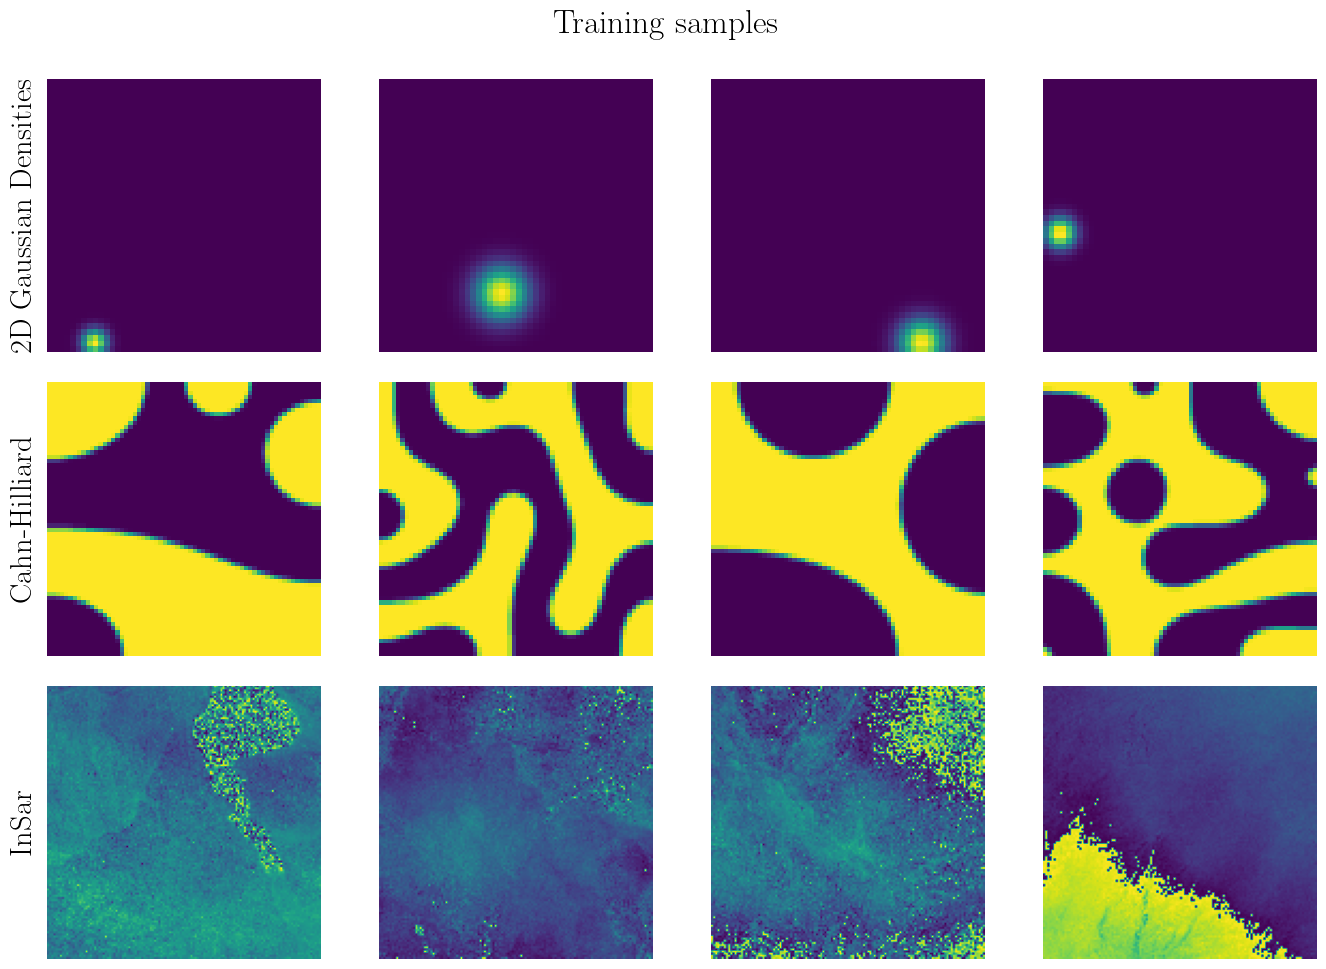

In [10]:
key = random.PRNGKey(12)
idx = random.choice(key, N, (num_samples,), replace=False)

plt.figure(figsize=(14,10))

plt.subplot(3, 4, 1, frameon=False)
plt.imshow(jnp.flipud(u_1[idx[0],...]))
plt.ylabel('2D Gaussian Densities')
plt.xticks([])
plt.yticks([])

plt.subplot(3, 4, 2)
plt.imshow(jnp.flipud(u_1[idx[1],...]))
plt.axis('off')

plt.subplot(3, 4, 3)
plt.imshow(jnp.flipud(u_1[idx[2],...]))
plt.axis('off')

plt.subplot(3, 4, 4)
plt.imshow(jnp.flipud(u_1[idx[3],...]))
plt.axis('off')

plt.subplot(3, 4, 5, frameon=False)
plt.imshow(jnp.flipud(u_2[idx[0],...]))
plt.ylabel('Cahn-Hilliard')
plt.xticks([])
plt.yticks([])

plt.subplot(3, 4, 6)
plt.imshow(jnp.flipud(u_2[idx[1],...]))
plt.axis('off')

plt.subplot(3, 4, 7)
plt.imshow(jnp.flipud(u_2[idx[2],...]))
plt.axis('off')

plt.subplot(3, 4, 8)
plt.imshow(jnp.flipud(u_2[idx[3],...]))
plt.axis('off')

plt.subplot(3, 4, 9, frameon=False)
plt.imshow(jnp.flipud(u_3[idx[0],...]))
plt.ylabel('InSar')
plt.xticks([])
plt.yticks([])

plt.subplot(3, 4, 10)
plt.imshow(jnp.flipud(u_3[idx[1],...]))
plt.axis('off')

plt.subplot(3, 4, 11)
plt.imshow(jnp.flipud(u_3[idx[2],...]))
plt.axis('off')

plt.subplot(3, 4, 12)
plt.imshow(jnp.flipud(u_3[idx[3],...]))
plt.axis('off')

plt.suptitle('Training samples') # or plt.suptitle('Main title')

plt.tight_layout()
plt.savefig('training_samples.png', dpi=300)
plt.show()

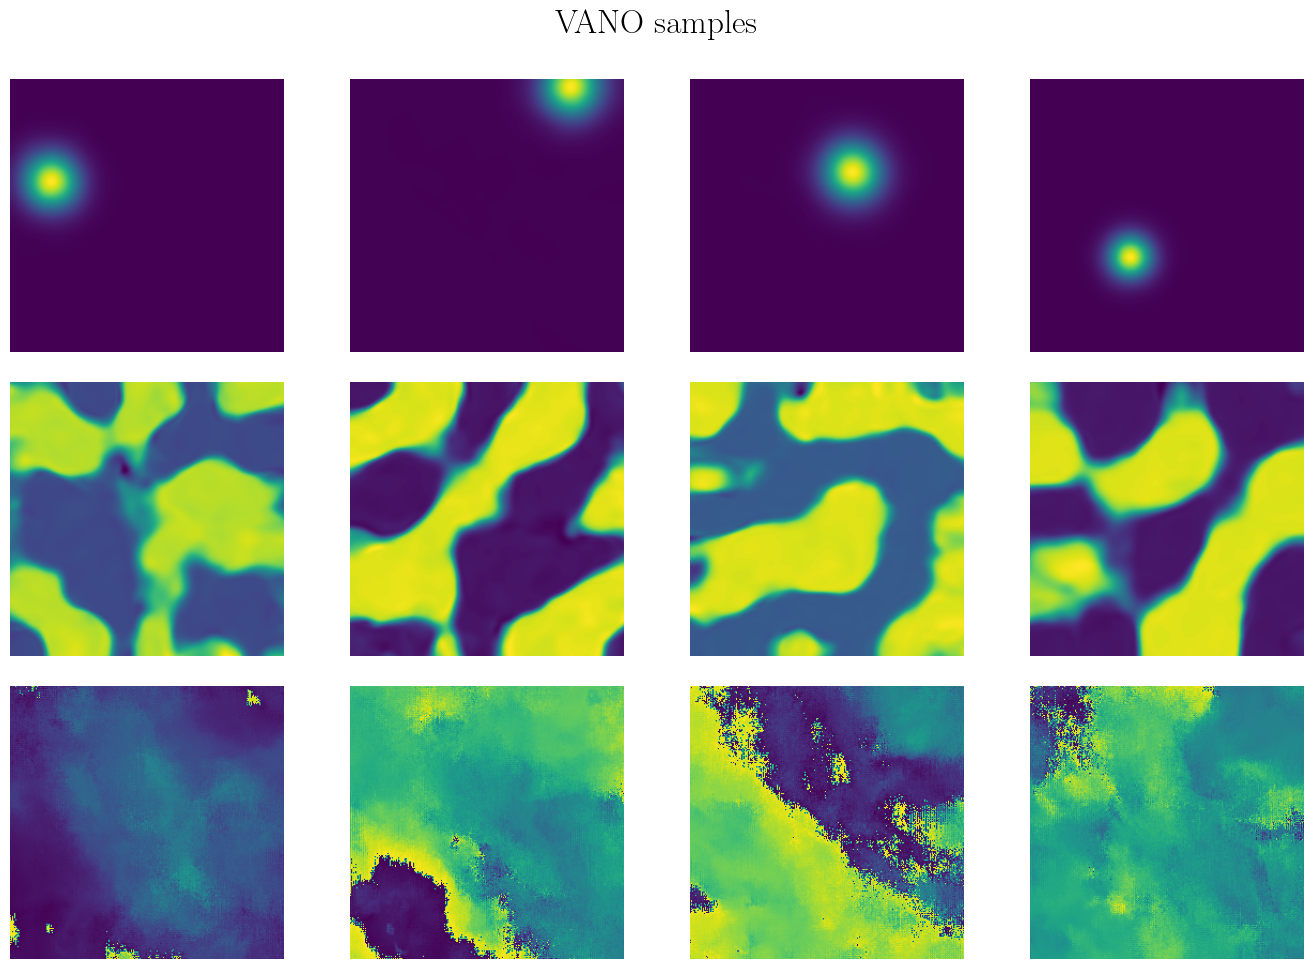

In [11]:

plt.figure(figsize=(14,10))

plt.subplot(3, 4, 1, frameon=False)
plt.imshow(jnp.flipud(samples_1[0,...]))
plt.axis('off')

plt.subplot(3, 4, 2)
plt.imshow(jnp.flipud(samples_1[1,...]))
plt.axis('off')

plt.subplot(3, 4, 3)
plt.imshow(jnp.flipud(samples_1[2,...]))
plt.axis('off')

plt.subplot(3, 4, 4)
plt.imshow(jnp.flipud(samples_1[3,...]))
plt.axis('off')

plt.subplot(3, 4, 5, frameon=False)
plt.imshow(jnp.flipud(samples_2[0,...]))
plt.axis('off')

plt.subplot(3, 4, 6)
plt.imshow(jnp.flipud(samples_2[1,...]))
plt.axis('off')

plt.subplot(3, 4, 7)
plt.imshow(jnp.flipud(samples_2[2,...]))
plt.axis('off')

plt.subplot(3, 4, 8)
plt.imshow(jnp.flipud(samples_2[3,...]))
plt.axis('off')

plt.subplot(3, 4, 9, frameon=False)
plt.imshow(jnp.flipud(samples_3[0,...]))
plt.axis('off')

plt.subplot(3, 4, 10)
plt.imshow(jnp.flipud(samples_3[1,...]))
plt.axis('off')

plt.subplot(3, 4, 11)
plt.imshow(jnp.flipud(samples_3[2,...]))
plt.axis('off')

plt.subplot(3, 4, 12)
plt.imshow(jnp.flipud(samples_3[3,...]))
plt.axis('off')

plt.suptitle('VANO samples') # or plt.suptitle('Main title')

plt.tight_layout()
plt.savefig('generated_samples.png', dpi=300)
plt.show()